# **Evaluation Metrics for Classification**

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction import DictVectorizer

In [2]:
df = pd.read_csv('C:/Users/osaze/Desktop/Git Projects/ml-zoomcamp-notes/Logistics regression/Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# convert column headers to lower case and replace space with _
# convert categorical column values to lower case and replace space with _

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [4]:
# convert total charges to number and replace nulls with 0
df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

# convert yes to 1 and no to 0 and convert the datatype to int
df.churn = (df.churn == 'yes').astype(int)

In [5]:
# split the dataset into train, validation and test sets
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

print(len(df_train), len(df_val), len(df_test))

# reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# seperate the target variables
y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

# delete the target valriables in the feature matrix
del df_train['churn']
del df_val['churn']
del df_test['churn']

df_full_train = df_full_train.reset_index(drop=True)

4225 1409 1409


In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']
full_list = numerical + categorical

In [7]:
df_to_dict = FunctionTransformer(
    lambda X: X.to_dict(orient="records"),
    validate=False
)

model = make_pipeline(df_to_dict, 
                      DictVectorizer(sparse = False), 
                      LogisticRegression(max_iter =5000))
model

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x00000237CB1740E0>)),
                ('dictvectorizer', DictVectorizer(sparse=False)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [8]:
model.fit(df_train[numerical + categorical], y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x00000237CB1740E0>)),
                ('dictvectorizer', DictVectorizer(sparse=False)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [9]:
y_pred = model.predict_proba(df_val)[:, 1]

churn_decision = (y_pred >= 0.5)

df = pd.DataFrame()
df['probability'] = y_pred
df['prediction'] = churn_decision.astype(int)
df['actual'] = y_val
df['correct'] = df.prediction == df.actual

# let us check the fraction of correct ones

print(f"Model Accuracy: {df.correct.mean()}")

Model Accuracy: 0.8041163946061036


### **Accuracy and dummy model**

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

***Accuracy is the proportion of correctly predicted samples out of the total number of predictions.***

$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$

In cases where the target variable is **class-imbalanced**, accuracy can be **misleading**, as a model may achieve a high accuracy by predicting only the majority class while performing poorly on the minority class.


In [10]:
from sklearn.metrics import accuracy_score

In [11]:
y_pred1 = model.predict(df_val)

In [12]:
score = accuracy_score(y_val, y_pred1)
print(f"Accuracy: {(score):.3f}")

Accuracy: 0.804


### **Confusion Table**

***Confusion Table** is a way of looking at different errors and correct decisions that the binary classification model makes.*

- Different types of errors and correct decisions
- Arranging them in a table

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
# noramlize parameter helps express the result in percentage
confusion_matrix(y_val, y_pred1, normalize='all').round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

***Rather than summarizing model performance with a single number, the confusion table presents four values that indicate how many correct and incorrect decisions the model makes.***

### **Precision and Recall**

In [15]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred1).ravel()

In [16]:
Accuracy = (tn + tp) / (tn + fp + fn + tp)
print(f"{Accuracy:.2f}")

0.80


***precision tells us the fraction of positive predictions that turned out to be correct***

In [17]:
precision = tp / (tp + fp)
print(f"{precision:.2f}")

0.68


***recall tells us the fraction of correctly identified positive predictions***

In [18]:
recall = tp / (tp + fn)
print(f"{recall:.2f}")

0.55


In [19]:
# calculating precision and recall using sklearn
from sklearn.metrics import precision_score, recall_score

In [20]:
precision = precision_score(y_val, y_pred1)

In [21]:
recall = recall_score(y_val, y_pred1)

In [22]:
print(f"precision: {precision:.2f}, recall: {recall:.2f}")

precision: 0.68, recall: 0.55


### **ROC Curves**

A ROC (Receiver Operating Characteristic) curve illustrates the trade-off between the True Positive Rate (TPR / Recall) and the False Positive Rate (FPR) across different classification thresholds. In other words, ROC curve shows how well a model can distinguish between classes as the decision threshold changes.

***The ideal model achieves a high true positive rate while keeping the false positive rate as low as possible***, which corresponds to points near the top-left corner of the ROC curve.

**True Positive Rate:** This tells us of all the actual positive, how many did we correctly identify. 
$$\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$


**False Positive Rate:** This tells us of all the actual negative, how many did we wrongly classify as positive.
$$\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}$$

In [23]:
from sklearn.metrics import roc_curve

In [24]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [25]:
import matplotlib.pyplot as plt

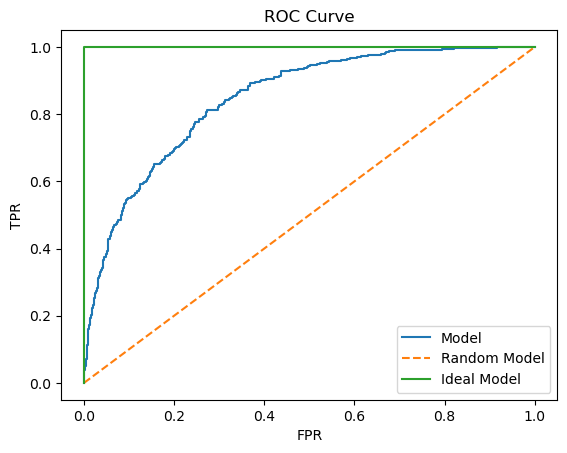

In [26]:
plt.plot(fpr, tpr, label = "Model")
plt.plot([0,1], [0,1], label = "Random Model", linestyle = "--")
plt.plot([0,0,0,1], [0,1,1,1], label = "Ideal Model")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()


- Top-left = ideal model

- Diagonal = random model

- Above diagonal = useful model

#### **The Ideal Model (Perfect Classifier)**
**What it looks like:**

- Goes straight up from (0,0) to (0,1)

- Then across from (0,1) to (1,1)

**Why?**

- FPR = 0 (no false positives)

- TPR = 1 (all positives correctly identified)

**This means:**

- It perfectly separates classes

- No mistakes

- AUC = 1.0


#### **The Random Model**
**What it looks like:**

- A diagonal straight line from (0,0) to (0,1)

**Why?**

Because:

- TPR increases at the same rate as FPR

- It’s guessing randomly

Mathematically:
$$TPR = FPR$$

**AUC = 0.5**

This means:
**The model has no ability to distinguish classes.**


**A ROC curve is not about accuracy, It answers: *How well can the model separate the two classes regardless of threshold?***

### **ROC AUC**

- Area under the ROC curve - useful metric
- Interpretation of AUC

***The AUC metric is the probability that a randomly chosen positive instance scores higher than a randomly chosen negative instance. This score reflects how well a model has learned to separate the classes, as opposed to essentially guessing. AUC is a ranking metric, not a performance metric at a specific classification threshold.***

In [27]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [28]:
print(roc_auc_score(y_val, y_pred))

0.8463449470469361


In [29]:
print(auc(fpr, tpr))

0.8463449470469361


### **Cross-Validation**

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

**Implementing Kfold Cross Validation**

In [30]:
from sklearn.model_selection import KFold, GridSearchCV

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [32]:
# Define parameter grid
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

In [33]:
grid = GridSearchCV (
    model,
    param_grid,
    cv=kfold,
    scoring = 'roc_auc'
)

grid.fit(df_train[numerical + categorical], y_train)

print("Best C:", grid.best_params_)
print("Best score:", grid.best_score_)

Best C: {'logisticregression__C': 1}
Best score: 0.8404095505031783


In [34]:
df_to_dict = FunctionTransformer(
    lambda X: X.to_dict(orient="records"),
    validate=False
)

model = make_pipeline(df_to_dict, 
                      DictVectorizer(sparse = False), 
                      LogisticRegression(C = 1, max_iter =5000))

In [35]:
model.fit(df_full_train[numerical+categorical], df_full_train.churn.values)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x00000237CB18B560>)),
                ('dictvectorizer', DictVectorizer(sparse=False)),
                ('logisticregression', LogisticRegression(C=1, max_iter=5000))])

In [37]:
prediction = model.predict_proba(df_test[numerical+categorical])[:,1]

auc = roc_auc_score(y_test, prediction)
print(auc)

0.8584627926376114
